In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

## Load data

In [48]:
# --- Load all results into a single dataframe ---
results_dir = "../results"

data = []
for file in os.listdir(results_dir):
    if file.endswith(".csv"):
        arch = file.split("_")[0]  # e.g., logreg, svm, xgboost
        df = pd.read_csv(os.path.join(results_dir, file))
        df["architecture"] = arch
        data.append(df)

results_df = pd.concat(data, ignore_index=True)
results_df = results_df.sort_values(by=["architecture", "dataset", "kmer"])
results_df.to_csv("../results/combined_results.csv", index=False)
results_df

,dataset,kmer,f1_val_macro,f1_test_macro,architecture
6,MLST,5,0.826797,0.840482,gradient-boosted
9,MLST,7,0.942288,0.944276,gradient-boosted
7,Serotype,5,0.833576,0.824969,gradient-boosted
10,Serotype,7,0.946607,0.939931,gradient-boosted
8,Subspecies,5,0.968045,0.991661,gradient-boosted
11,Subspecies,7,0.979156,1.000000,gradient-boosted
12,MLST,5,0.979949,0.980668,linear-SVM
15,MLST,7,0.991871,0.992853,linear-SVM
13,Serotype,5,0.980149,0.986529,linear-SVM
16,Serotype,7,0.986859,0.991340,linear-SVM


## Plot macro-averaged F1 scores

/scratch/tmp/ipykernel_2952296/2343404369.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


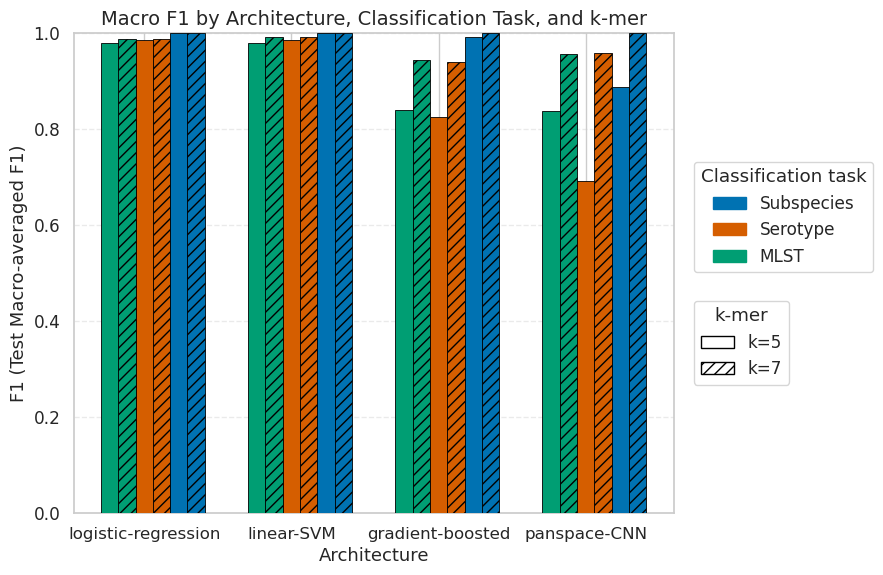

In [50]:
# --- Style maps ---
color_map = {
    "Subspecies": "#0072B2",  # blue
    "Serotype": "#D55E00",    # orange
    "MLST": "#009E73"         # green
}
hatch_map = {5: '', 7: '///'}

# --- Desired explicit order ---
arch_order = ["logistic-regression", "linear-SVM", "gradient-boosted", "panspace-CNN"]
dataset_order = ["MLST", "Serotype", "Subspecies"]
kmer_order = [5, 7]   # ensure these are ints in the DF

# make sure column types match
results_df = results_df.copy()
results_df["architecture"] = results_df["architecture"].astype(str)
results_df["dataset"] = results_df["dataset"].astype(str)
results_df["kmer"] = results_df["kmer"].astype(int)

# --- Layout parameters (tweak widths/spacing if you'd like) ---
bar_width = 0.12          # width of a single bar
dataset_gap = 0        # gap between dataset groups inside an architecture
arch_gap = 0.3            # gap between architecture blocks

n_datasets = len(dataset_order)
n_kmers = len(kmer_order)
bars_per_dataset = n_kmers
per_dataset_block = bars_per_dataset * bar_width + dataset_gap
total_group_width = n_datasets * per_dataset_block - dataset_gap  # total width for one architecture block

# --- Plot setup ---
sns.set(style="whitegrid", font_scale=1.1)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0.08, 0.1, 0.5, 0.8]) # left, bottom, width, height

# store x positions to compute tick centers
arch_centers = []

# Draw bars explicitly in the exact order
for i, arch in enumerate(arch_order):
    base = i * (total_group_width + arch_gap)  # leftmost x for this architecture
    # center for the architecture tick
    arch_centers.append(base + total_group_width / 2 - bar_width/2)
    for j, ds in enumerate(dataset_order):
        for k_idx, kmer in enumerate(kmer_order):
            xpos = base + j * per_dataset_block + k_idx * bar_width
            # fetch the value (there should be exactly one row matching)
            mask = (
                (results_df["architecture"] == arch) &
                (results_df["dataset"] == ds) &
                (results_df["kmer"] == int(kmer))
            )
            if mask.any():
                value = float(results_df.loc[mask, "f1_test_macro"].iloc[0])
            else:
                value = 0.0  # fallback if missing
            # draw the bar
            bar = ax.bar(
                xpos,
                value,
                width=bar_width,
                align="edge",
                color=color_map[ds],
                hatch=hatch_map[kmer],
                edgecolor="black",
                linewidth=0.6,
                zorder=3
            )

# --- Axis formatting ---
#ax.set_xlim(-0.1, arch_order.__len__() * (total_group_width + arch_gap) - arch_gap + 0.1)
ax.set_xticks(arch_centers)
ax.set_xticklabels(arch_order, fontsize=12)
ax.set_ylabel("F1 (Test Macro-averaged F1)", fontsize=13)
ax.set_xlabel("Architecture", fontsize=13)
ax.set_ylim(0, 1)   # full 0–1 scale
ax.grid(axis="y", linestyle="--", alpha=0.4, zorder=0)
plt.title("Macro F1 by Architecture, Classification Task, and k-mer", fontsize=14)

# --- Legends ---
dataset_patches = [mpatches.Patch(color=c, label=d) for d, c in color_map.items()]
kmer_patches = [mpatches.Patch(facecolor='white', edgecolor='black', hatch=h, label=f'k={k}') for k, h in hatch_map.items()]

# legend1 = ax.legend(handles=dataset_patches, title="Classification task",
#                     loc='upper left', bbox_to_anchor=(1, 1))
# 
legend1 = ax.legend(handles=kmer_patches, title="k-mer",
           loc='lower left', bbox_to_anchor=(1.02, 0.25))
ax.add_artist(legend1)

ax.legend(handles=dataset_patches, title="Classification task",
                    loc='upper left', bbox_to_anchor=(1.02, 0.75))

plt.tight_layout()
plt.savefig("../figures/f1_barplot.png", dpi=300, bbox_inches="tight")
plt.show()

# Summarize in table format

In [45]:
summary = (
    results_df.groupby(["architecture", "dataset"])["f1_test_macro"]
      .agg(["mean", "std"])
      .reset_index()
)

# Create formatted summary column
summary["summary"] = summary["mean"].round(3).astype(str) + " ± " + summary["std"].round(3).astype(str)

# Pivot for display
styled_summary = summary.pivot(index="architecture", columns="dataset", values="summary")

def highlight_max(s):
    numeric_vals = s.str.extract(r'([\d.]+)').astype(float)
    is_max = numeric_vals[0] == numeric_vals[0].max()
    return ['background-color: #3b82f6; color: white; font-weight: bold;' if v else '' for v in is_max]

styled_summary.style \
    .set_caption("F1 Test Macro (mean ± std) by Architecture and Dataset") \
    .set_table_styles([
        {"selector": "caption",
         "props": [("caption-side", "top"), ("font-size", "16px"), ("font-weight", "bold")]}
    ]) \
    .apply(highlight_max, axis=0) \
    .set_properties(**{"text-align": "center", "font-size": "14px"})

dataset,MLST,Serotype,Subspecies
architecture,,,
gradient-boosted,0.892 ± 0.073,0.882 ± 0.081,0.996 ± 0.006
linear-SVM,0.987 ± 0.009,0.989 ± 0.003,1.0 ± 0.0
logistic-regression,0.984 ± 0.007,0.986 ± 0.002,1.0 ± 0.0
panspace-CNN,0.898 ± 0.084,0.825 ± 0.188,0.944 ± 0.08


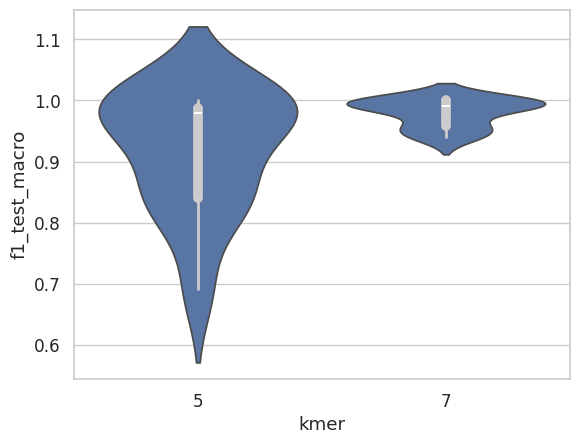

In [51]:
sns.violinplot(data=results_df, x="kmer", y="f1_test_macro", density_norm="count", inner_kws=dict(box_width=7, whis_width=2, color=".8"))
plt.savefig("../figures/f1_violin_kmer.png", dpi=300, bbox_inches="tight")

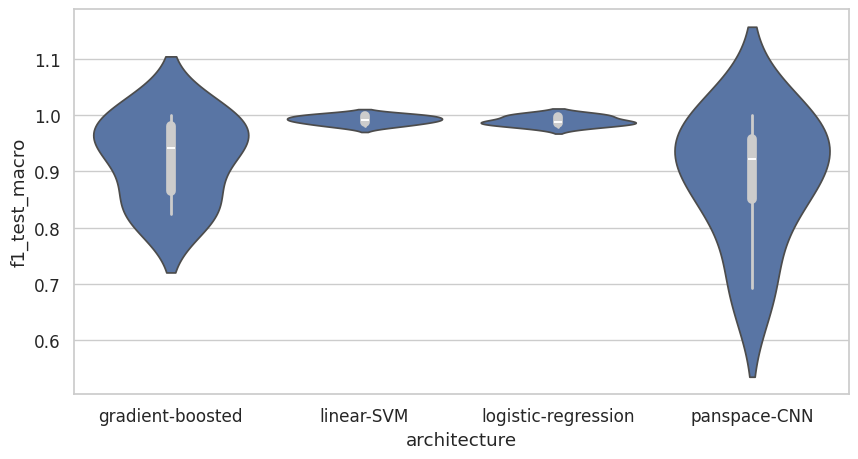

In [52]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=results_df, x="architecture", y="f1_test_macro", density_norm="count", inner_kws=dict(box_width=7, whis_width=2, color=".8"))
plt.savefig("../figures/f1_violin_architeture.png", dpi=300, bbox_inches="tight")